#### Normal CNN for the Bird classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
DIR_TRAIN = '../Data/Use/Train/'
DIR_TEST = '../Data/Use/Test/'
DIR_VALID = '../Data/Use/Valid/'

In [4]:
os.listdir(DIR_TRAIN)

['CASPIAN TERN',
 'D-ARNAUDS BARBET',
 'DARK EYED JUNCO',
 'HOUSE FINCH',
 'OVENBIRD',
 'OYSTER CATCHER',
 'RED TAILED HAWK',
 'SWINHOES PHEASANT',
 'VIOLET GREEN SWALLOW',
 'WOOD DUCK']

In [11]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_datagen = train_datagen.flow_from_directory(DIR_TRAIN,
                                                target_size=(100,100), 
                                                color_mode='rgb', 
                                                class_mode='categorical', 
                                                batch_size=16,
                                                shuffle=True)

test_datagen = test_datagen.flow_from_directory(DIR_TEST,
                                                target_size=(100,100),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                batch_size=16,
                                                shuffle=True)

valid_datagen = valid_datagen.flow_from_directory(DIR_VALID,
                                                target_size=(100,100), 
                                                color_mode='rgb', 
                                                class_mode='categorical', 
                                                batch_size=16,
                                                shuffle=True)

Found 1000 images belonging to 10 classes.
Found 50 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [12]:
class ConvNet(tf.keras.Model):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.layer = [
            tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'),
            tf.keras.layers.AveragePooling2D(pool_size=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(2,2)),
            tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPool2D(pool_size=(3,3)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=50, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(10, activation='softmax')
        ]

    def call(self, x):

        for i in self.layer:
            x = i(x)
        return x

In [13]:
net = ConvNet()

net.build(input_shape=(16, 100, 100, 3))
net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
net.summary()

Model: "conv_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            multiple                  448       
_________________________________________________________________
average_pooling2d_1 (Average multiple                  0         
_________________________________________________________________
batch_normalization_3 (Batch multiple                  64        
_________________________________________________________________
conv2d_4 (Conv2D)            multiple                  4640      
_________________________________________________________________
batch_normalization_4 (Batch multiple                  128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_5 (Conv2D)            multiple                  1

In [15]:
net.fit(train_datagen, epochs=50, validation_data=valid_datagen)

Epoch 1/50
63/63 [==============================] - 3s 34ms/step - loss: 2.2934 - accuracy: 0.2540 - val_loss: 4.4014 - val_accuracy: 0.1200
Epoch 2/50
63/63 [==============================] - 2s 27ms/step - loss: 1.7408 - accuracy: 0.4130 - val_loss: 7.2794 - val_accuracy: 0.0800
Epoch 3/50
63/63 [==============================] - 2s 30ms/step - loss: 1.4142 - accuracy: 0.5300 - val_loss: 8.2443 - val_accuracy: 0.1000
Epoch 4/50
63/63 [==============================] - 2s 30ms/step - loss: 1.1578 - accuracy: 0.6140 - val_loss: 7.7348 - val_accuracy: 0.1200
Epoch 5/50
63/63 [==============================] - 2s 32ms/step - loss: 0.9426 - accuracy: 0.6680 - val_loss: 7.7036 - val_accuracy: 0.2200
Epoch 6/50
63/63 [==============================] - 2s 31ms/step - loss: 0.7336 - accuracy: 0.7460 - val_loss: 5.4982 - val_accuracy: 0.3000
Epoch 7/50
63/63 [==============================] - 2s 31ms/step - loss: 0.6603 - accuracy: 0.7820 - val_loss: 1.8050 - val_accuracy: 0.5400
Epoch 8/50
63

In [16]:
net.evaluate(test_datagen)

4/4 [==============================] - 0s 28ms/step - loss: 0.9742 - accuracy: 0.8600


[0.9741924405097961, 0.8600000143051147]

#### Predicting a bird

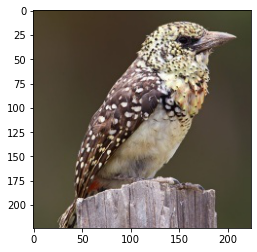

In [82]:
# Load a random image
path = np.random.choice(os.listdir(DIR_VALID))
img = np.random.choice(os.listdir(DIR_VALID + path))
img = Image.open(DIR_VALID + path + '/' + img)

plt.imshow(img)

img = tf.expand_dims(img, 0)
img = tf.cast(img, tf.float32)
img = tf.image.resize(img, (100,100))
img = img / 255.0

In [83]:
preds = net.predict(img)
preds_dict = {}

for n,i in enumerate(preds[0]):
    preds_dict[os.listdir(DIR_VALID)[n]] = i

preds_dict = sorted(preds_dict.items(), key=lambda x: x[1], reverse=True)

print('Actual:', path, '- Predicted:', os.listdir(DIR_VALID)[np.argmax(preds[0])],'\n')

for i in preds_dict:
    print(f'{i[1]:.2f}', i[0])

Actual: D-ARNAUDS BARBET - Predicted: D-ARNAUDS BARBET 

0.99 D-ARNAUDS BARBET
0.01 HOUSE FINCH
0.00 OVENBIRD
0.00 WOOD DUCK
0.00 SWINHOES PHEASANT
0.00 DARK EYED JUNCO
0.00 RED TAILED HAWK
0.00 VIOLET GREEN SWALLOW
0.00 OYSTER CATCHER
0.00 CASPIAN TERN


#### Confusion Matrix

In [58]:
X = np.concatenate([train_datagen.next()[0] for i in range(train_datagen.__len__())])
Y = np.concatenate([train_datagen.next()[1] for i in range(train_datagen.__len__())])
print(X.shape, Y.shape)

(1000, 100, 100, 3) (1000, 10)


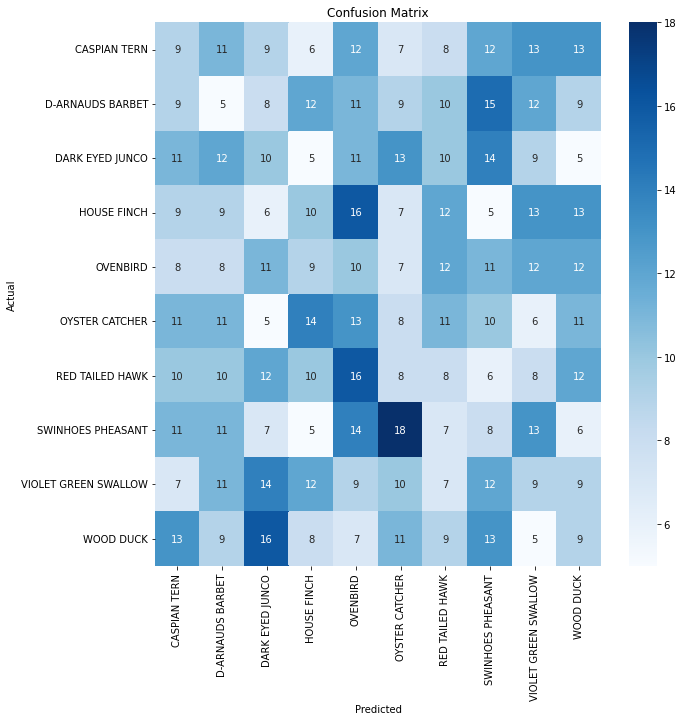

In [59]:
from sklearn.manifold import TSNE
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix

# Make a confusion matrix
conf = confusion_matrix(np.argmax(Y, axis=1), np.argmax(net.predict(X), axis=1))

plt.figure(figsize=(10,10))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=os.listdir(DIR_VALID), yticklabels=os.listdir(DIR_VALID))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
